In [1]:
%load_ext autoreload
%autoreload 2
import sys;sys.path.append('modules')
from utils import *

%matplotlib inline    
import matplotlib.pyplot as plt

# Info about fill

In [2]:
fill_number = 6711
fill_info = get_fill_info(fill_number)

# BBQ: TbT - remove overlap

In [96]:
modes = ['STABLE']
time = {}
time['STABLE'] = (pd.Timestamp('2018-05-22 03:07:20+00:00'), pd.Timestamp('2018-05-22 03:07:22+00:00') )
df = get_data(modes, time, rename_duplicates=False, remove_overlap=True)

# Keep 7000 sliding windows for both obsbox + BBQ
df.B1.H.tbt.STABLE = df.B1.H.tbt.STABLE[df.B1.H.tbt.STABLE.index<7000]
df.B2.H.tbt.STABLE = df.B2.H.tbt.STABLE[df.B2.H.tbt.STABLE.index<7000]
df.B1.V.tbt.STABLE = df.B1.V.tbt.STABLE[df.B1.V.tbt.STABLE.index<7000]
df.B2.V.tbt.STABLE = df.B2.V.tbt.STABLE[df.B2.V.tbt.STABLE.index<7000]

Flatten: ...
average overlap 248.64 samples
Flatten: ...
average overlap 248.64 samples
Flatten: ...
average overlap 248.73 samples
Flatten: ...
average overlap 248.73 samples


# BBQ: Organize 50 Hz h by FFT - sliding window 8000 turns

In [97]:
df_fft = get_fft(df)

B1 H STABLE
B1 V STABLE
B2 H STABLE
B2 V STABLE


# BBQ: Time evolution of phase of 50 Hz harmonics

B1 H STABLE
B1 H STABLE


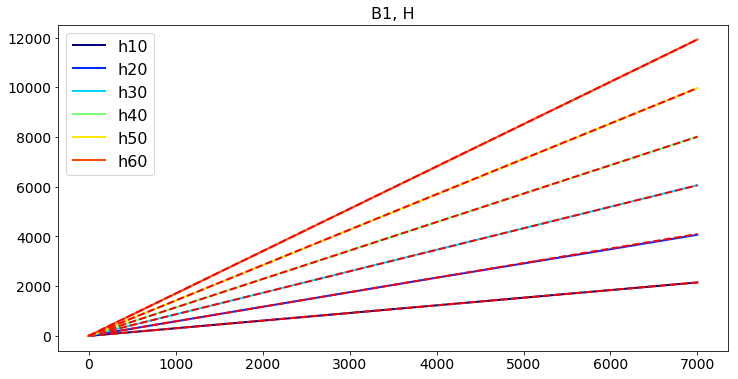

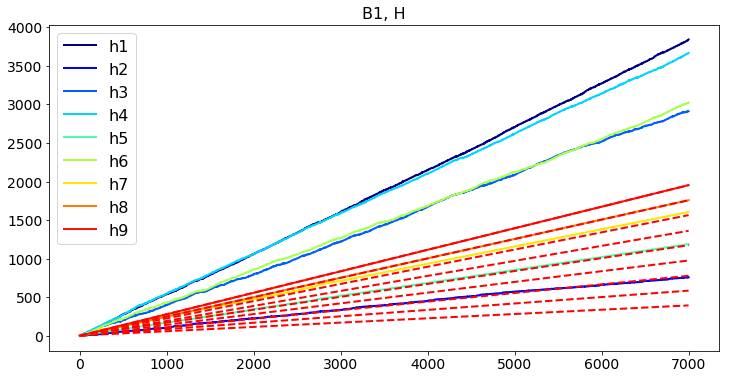

In [91]:
hs = np.arange(10,70,10)
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
hs = np.arange(1,10,1)
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)

# BBQ: phase heatmaps

B1 H STABLE
300  strongest absolute correlations
Top Absolute Correlations
4    42     0.999929
1    35     0.999921
35   111    0.999903
42   58     0.999901
58   111    0.999900
4    58     0.999894
1    111    0.999891
     110    0.999885
0    35     0.999878
35   58     0.999859
0    1      0.999833
1    58     0.999824
0    111    0.999823
42   111    0.999806
1    23     0.999788
0    58     0.999786
23   35     0.999784
35   42     0.999784
4    110    0.999783
35   110    0.999779
110  111    0.999774
4    111    0.999773
1    4      0.999765
     42     0.999758
     6      0.999755
4    40     0.999754
23   111    0.999750
4    35     0.999748
42   110    0.999732
0    23     0.999722
              ...   
81   107    0.998161
4    102    0.998152
     44     0.998150
1    47     0.998148
11   108    0.998137
30   33     0.998137
     83     0.998136
42   107    0.998125
     44     0.998120
39   111    0.998108
30   44     0.998102
4    108    0.998098
1    39     0.998095
0

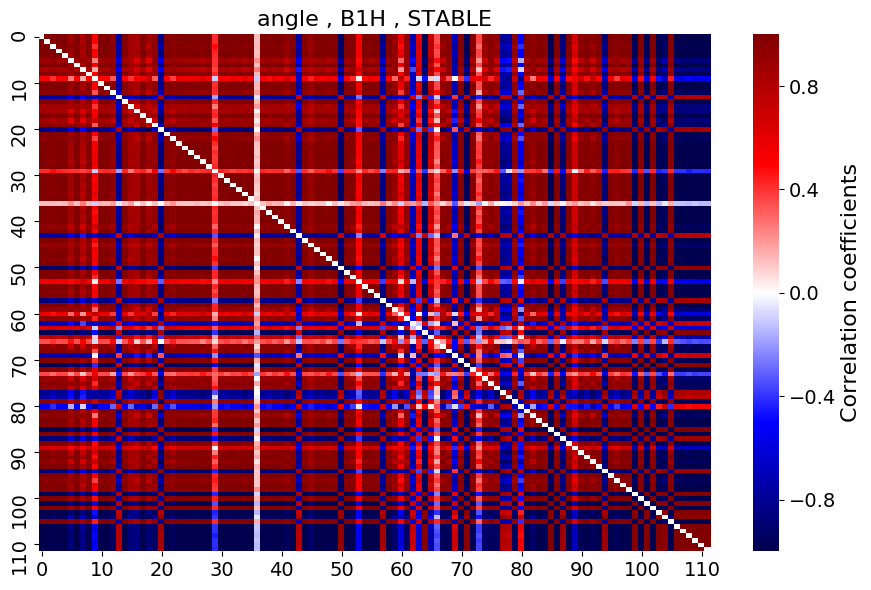

In [111]:
corr, strongest, bins, pvals = heatmaps(df_fft, status=['STABLE'], beam=['B1'], plane=['H'], mode='angle')
plt.show()

# Obsbox

In [113]:
from dateutil import tz
import os
import datetime
import calendar
import h5py as h5

df = importData.LHCFillsByNumber(fill_number)
df.to_csv('LHCFillsByNumber')
df = df[df['mode']!='FILL']
df = df.reset_index(drop=True)

b1h = ['/eos/user/s/skostogl/SWAN_projects/MD_noise/obsbox_fill6711/06711_Inst_B1H_Q7_20180522_05h07m20s.h5']

bb = [b1h]
beam = ['B1']
plane = ['horizontal']
cc = ['r']

counter=0
for b in bb:

  print '######## %s ########' %b[0].split('/')[-1].split('_')[2]
  for filename in b[:]:
    #fig, ax = plt.subplots(figsize=(8,6))
    date = (filename.split('_')[-2])
    time = (filename.split('_')[-1]).split('.')[0]
    date2 = ((datetime.datetime.strptime(date+time, "%Y%m%d%Hh%Mm%Ss")))
    date_current = ((datetime.datetime.strptime(date+time, "%Y%m%d%Hh%Mm%Ss")).replace(tzinfo=tz.gettz('CET'))).astimezone(tz.gettz('UTC'))
    print "File at: ",  date2, ' Status: ' , df[(df['startTime']<=date_current)  & (df['endTime']>=date_current)]['mode'].values
    fi = h5.File(filename, 'r')
    alldat = fi[beam[counter]][plane[counter]]

######## B1H ########
File at:  2018-05-22 05:07:20  Status:  [u'STABLE']


# Obsbox: Get frev from BBQ

In [114]:
print alldat
frf = 400789732.928
h = 35640
frev =  frf/h

<HDF5 dataset "horizontal": shape (65536, 3564), type "<i2">


# Obsbox: sliding window 8000 turns for all bunches

In [67]:
### This will take a while

lim =112
lists = [[] for j in range(lim)]
cc = ['r']

df_fft2 = dotdict.dotdict()
key = 'h'
n = 8000
for max_i in range(n, 15000): 
  print  max_i
  min_i = max_i -n
  fftdat = (np.fft.fft(alldat[min_i:max_i,:],axis=0))
  fftfreq = np.fft.fftfreq(fftdat.shape[0])
  sumFFT = (np.sum(fftdat,axis=1))
  status = 'STABLE'
  freqs = np.fft.fftshift(fftfreq)  
  fourier =  np.fft.fftshift(sumFFT)
  harm = 50. / (frf / h)
  #### Need to add len(sumFFT)/2 due to fftshift
  indexes = [ int(k * harm * len(sumFFT) +len(sumFFT)/2. )   for k in range(1, lim+1) ]
  turns = min_i
  beam = 'B1'
  plane = 'H'
  date = '2018-05-22 05:07:20'
  for j in range(len(indexes)):
    lists[j].append([status,j, indexes[j],freqs[indexes[j]], fourier[indexes[j]], date, turns, beam, plane])
for j in range(lim):
  df_fft2['%s%s' %(key,str(j))] = pd.DataFrame(data = lists[j], columns = ['status', 'h', 'bin','f','fourier', 'timestamps', 'turns', 'beam', 'plane']) 

8000
8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011
8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023
8024
8025
8026
8027
8028
8029
8030
8031
8032
8033
8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045
8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061
8062
8063
8064
8065
8066
8067
8068
8069
8070
8071
8072
8073
8074
8075
8076
8077
8078
8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091
8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199


9639
9640
9641
9642
9643
9644
9645
9646
9647
9648
9649
9650
9651
9652
9653
9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665
9666
9667
9668
9669
9670
9671
9672
9673
9674
9675
9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691
9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704
9705
9706
9707
9708
9709
9710
9711
9712
9713
9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725
9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738
9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751
9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763
9764
9765
9766
9767
9768
9769
9770
9771
9772
9773
9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785
9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798
9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811
9812
9813
9814
9815
9816
9817
9818
9819
9820
9821
9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834
9835
9836
9837
9838


11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075
11076
11077
11078
11079
11080
11081
11082
11083
11084
11085
11086
11087
11088
11089
11090
11091
11092
11093
11094
11095
11096
11097
11098
11099
11100
11101
11102
11103
11104
11105
11106
11107
11108
11109
11110
11111
11112
11113
11114
11115
11116
11117
11118
11119
11120
11121
11122
11123
11124
11125
11126
11127
11128
11129
11130
11131
11132
11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146
11147
11148
11149
11150
11151
11152
11153
11154
11155
11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168
11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181
11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194
11195
11196
11197
11198
11199
11200
11201
11202
11203
11204
11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215
11216
11217
11218
11219
11220
11221
11222
11223
11224
11225
11226
11227
11228
11229
11230
1123

12431
12432
12433
12434
12435
12436
12437
12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454
12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469
12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481
12482
12483
12484
12485
12486
12487
12488
12489
12490
12491
12492
12493
12494
12495
12496
12497
12498
12499
12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514
12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527
12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538
12539
12540
12541
12542
12543
12544
12545
12546
12547
12548
12549
12550
12551
12552
12553
12554
12555
12556
12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
1259

13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927
13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939
13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952
13953
13954
13955
13956
13957
13958
13959
13960
13961
13962
1396

# Obsbox: time evolution 

B1 H STABLE
B1 H STABLE


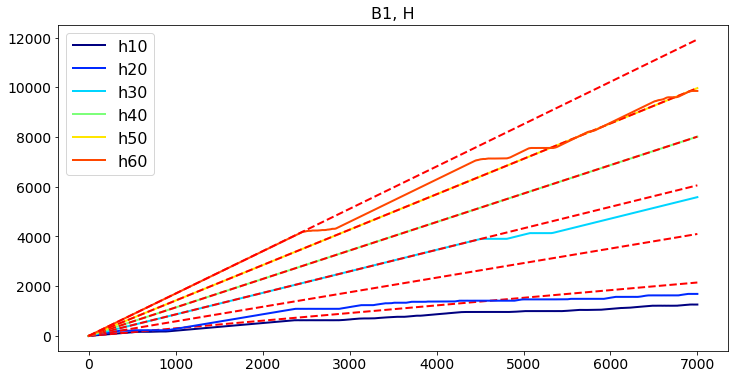

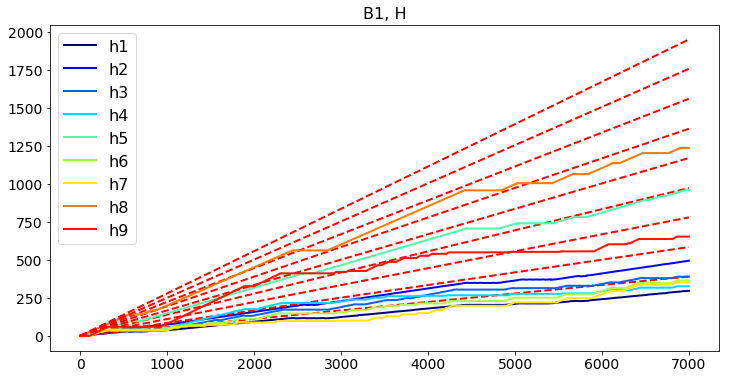

In [69]:
hs = np.arange(10,70,10)
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
hs = np.arange(1,10,1)
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)

B1 H STABLE
B1 H STABLE


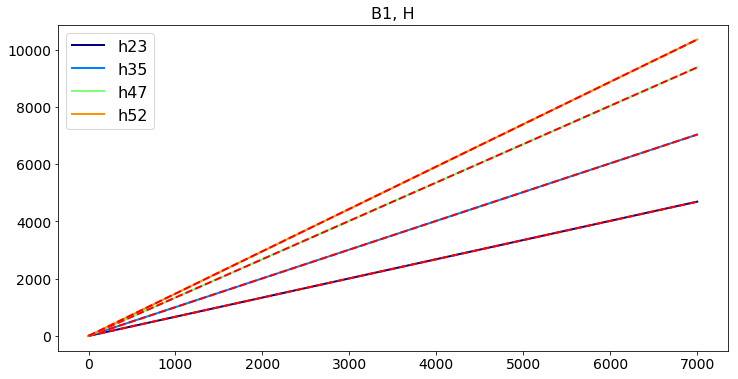

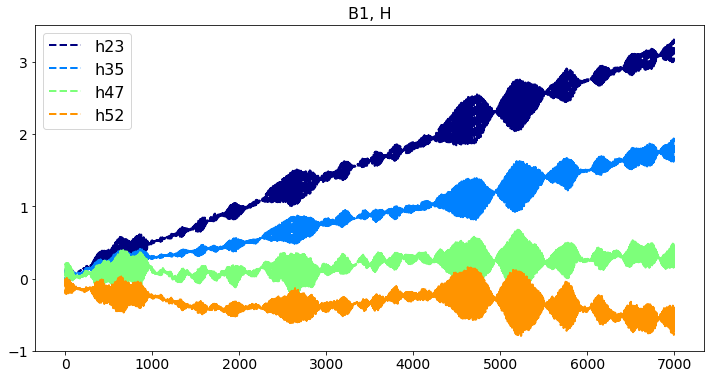

In [78]:
hs = [23,35, 47, 52]
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', remove_slope=True)

B1 H STABLE
300  strongest absolute correlations
Top Absolute Correlations
110  111    0.999823
104  109    0.999807
108  111    0.999724
68   81     0.999696
17   45     0.999677
107  109    0.999629
6    108    0.999557
97   107    0.999529
104  106    0.999526
97   109    0.999519
9    103    0.999466
4    9      0.999442
108  110    0.999430
9    105    0.999384
24   30     0.999378
106  109    0.999334
104  107    0.999323
30   51     0.999296
84   102    0.999293
6    111    0.999291
17   28     0.999286
3    102    0.999248
32   103    0.999206
86   100    0.999154
32   105    0.999149
97   104    0.999147
     101    0.999126
28   45     0.999113
91   99     0.999063
88   99     0.999054
              ...   
3    104    0.994991
7    83     0.994986
15   98     0.994960
3    10     0.994940
13   25     0.994936
45   75     0.994931
88   98     0.994924
8    16     0.994908
84   106    0.994907
91   103    0.994901
6    46     0.994889
3    94     0.994845
53   60     0.994814
8

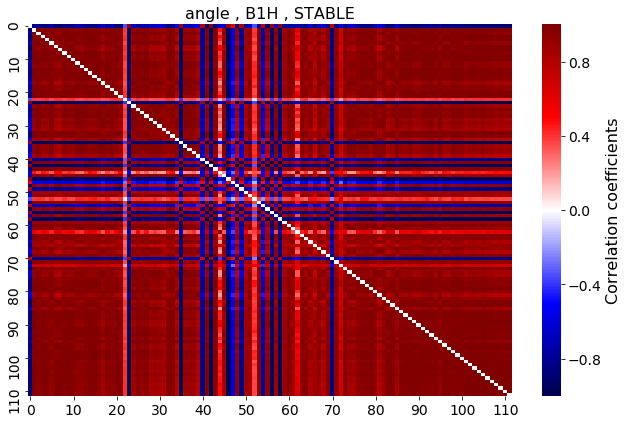

In [76]:
#fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10),sharex=True, sharey=True)
corr, strongest, bins, pvals = heatmaps(df_fft2, status=['STABLE'], beam=['B1'], plane=['H'], mode='angle')
plt.show()

# Compare obsbox & BBQ

B1 H STABLE
B1 H STABLE


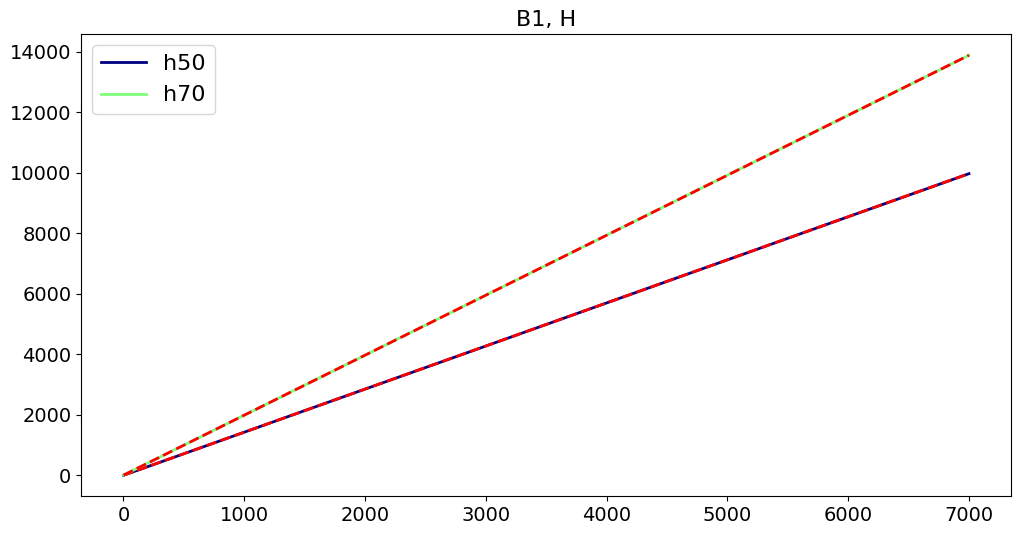

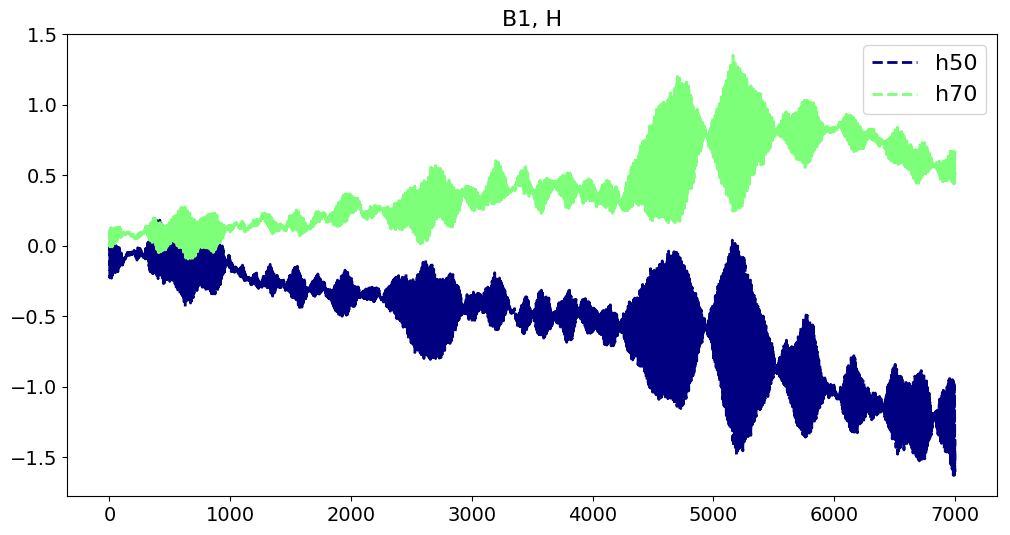

In [128]:
hs = [50,70]
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', remove_slope=True)

B1 H STABLE
B1 H STABLE


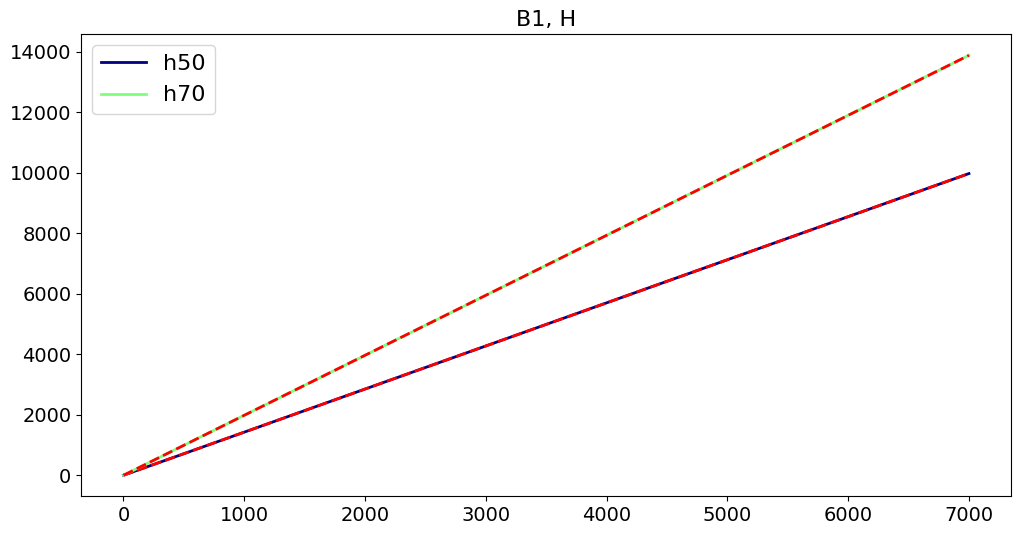

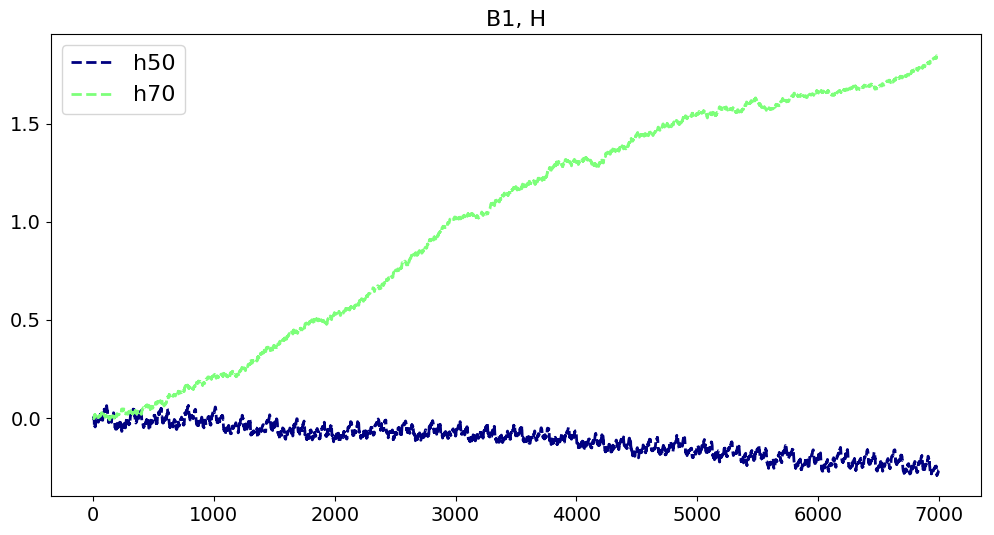

In [129]:
hs = [50,70]
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', remove_slope=True)

B1 H STABLE
B1 H STABLE


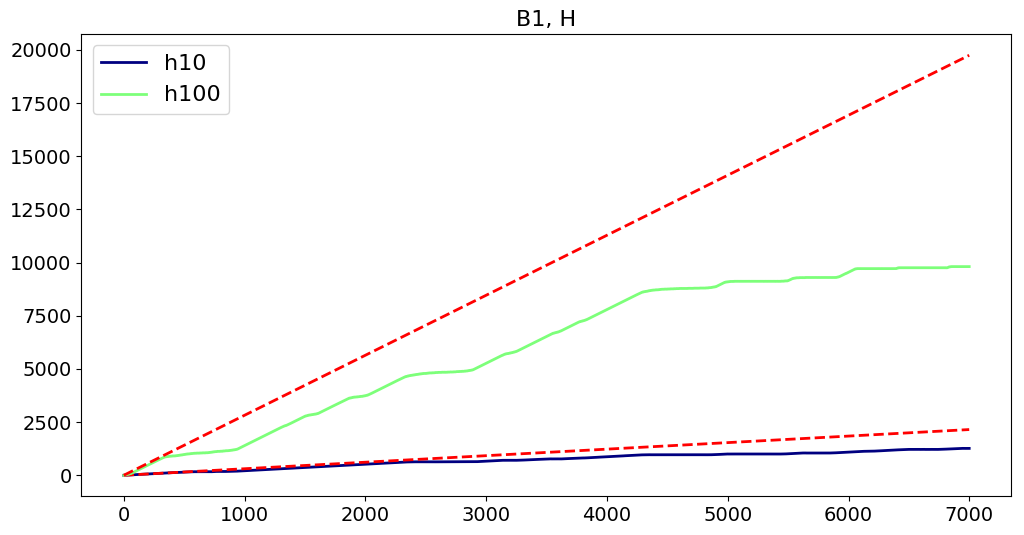

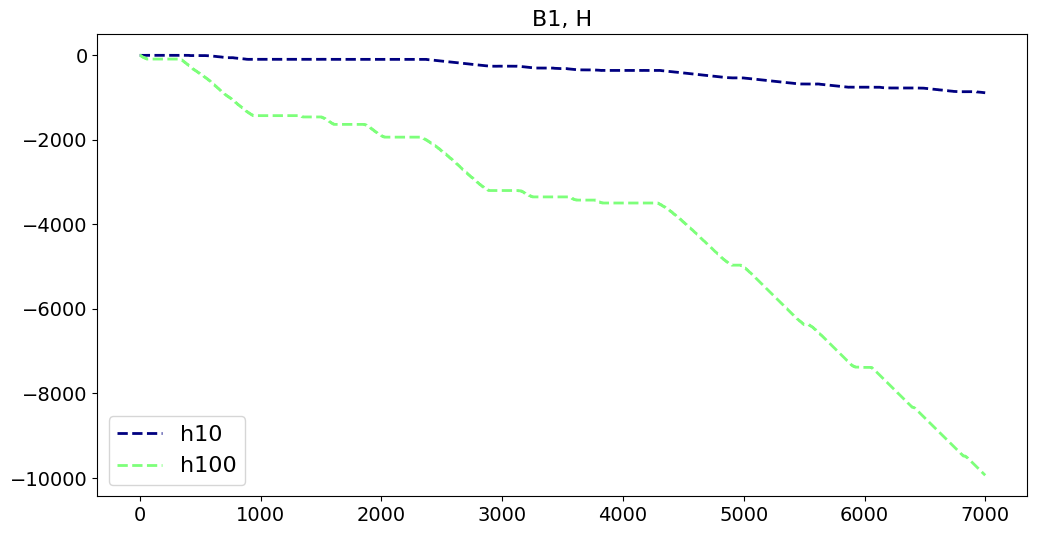

In [136]:
hs = [10,100]
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
plot_harm(hs, df_fft2, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', remove_slope=True)

B1 H STABLE
B1 H STABLE


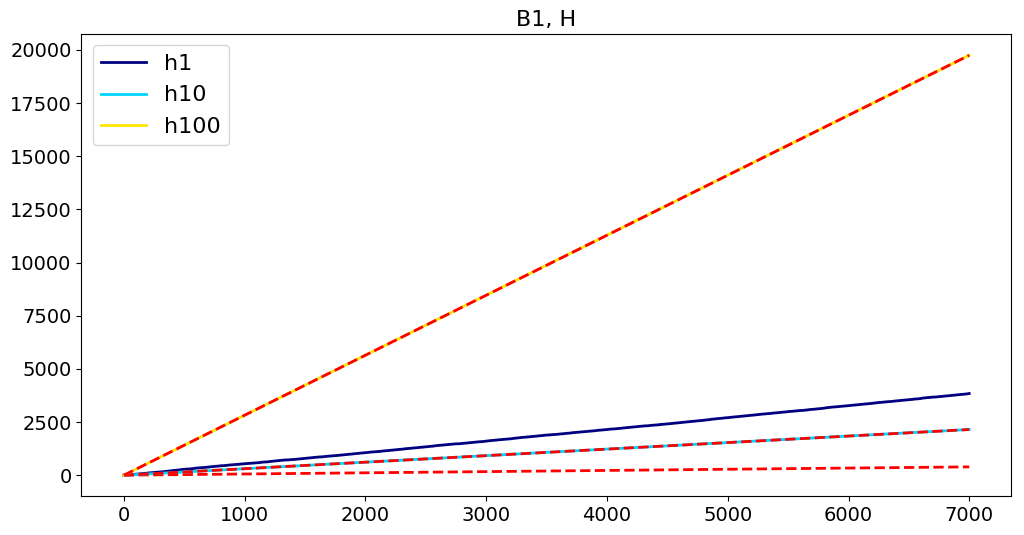

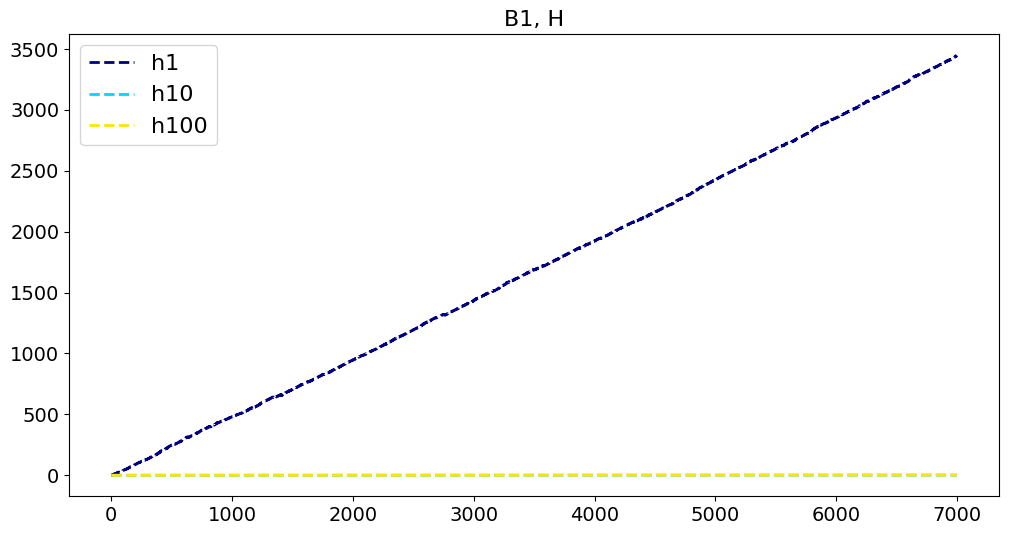

In [135]:
hs = [10,100]
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', fit_slope=True)
plot_harm(hs, df_fft, status = ['STABLE'],beam = ['B1'], plane=['H'], mode='angle', remove_slope=True)